# Ungraded Lab: Using a multi-layer LSTM for forecasting

In this lab, you will use the same RNN architecure in the first lab but will instead stack [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers instead of `SimpleRNN`.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-10-10 10:58:52.579758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 10:58:52.592424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 10:58:52.606171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 10:58:52.609924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 10:58:52.621054: I tensorflow/core/platform/cpu_feature_guar

## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

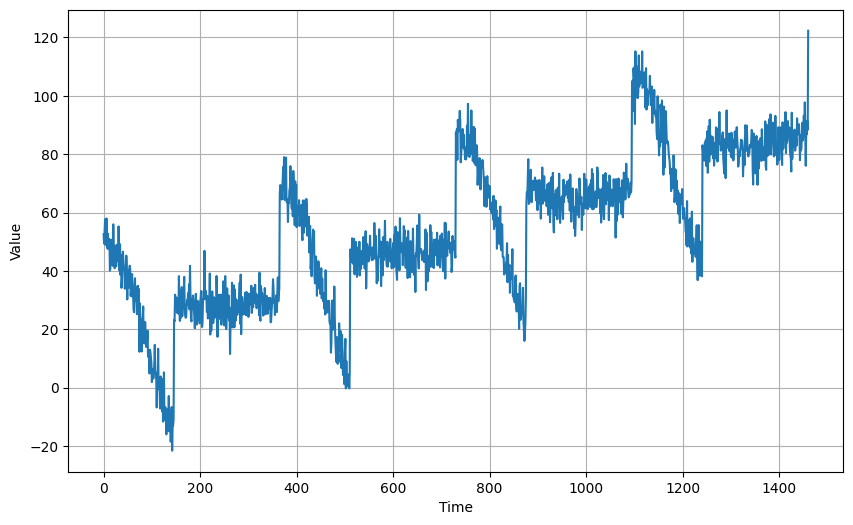

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

I0000 00:00:1728568734.542414  173213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728568734.577826  173213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728568734.577870  173213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728568734.582411  173213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728568734.582783  173213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## Build the Model

As mentioned, you will swap `SimpleRNN` for `LSTM` in this lab. It is also set as bidirectional below but feel free to revise later and see what results you get. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and you'll see that when you print the model summary below.

In [8]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will pick a learning rate by running the tuning code below.

In [9]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2024-10-10 10:59:02.336222: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 82.0607 - learning_rate: 1.0000e-08
Epoch 2/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 81.5267

2024-10-10 10:59:03.728397: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 10:59:03.728460: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/bidirectional_1/forward_lstm_1/Shape/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 81.1698 - learning_rate: 1.1220e-08
Epoch 3/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 80.3526

2024-10-10 10:59:04.217543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:04.217606: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 80.0032 - learning_rate: 1.2589e-08
Epoch 4/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 79.0463

2024-10-10 10:59:04.659879: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:04.659931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 78.6784 - learning_rate: 1.4125e-08
Epoch 5/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 77.5807

2024-10-10 10:59:05.088008: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-10-10 10:59:05.088056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:05.088064: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:05.088067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:05.088070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 77.1947 - learning_rate: 1.5849e-08
Epoch 6/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 75.9306

2024-10-10 10:59:05.507192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:05.507243: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:05.507251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:05.507258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 75.5226 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 73.6122 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 71.4383 - learning_rate: 2.2387e-08
Epoch 9/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 69.5172

2024-10-10 10:59:06.791369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:06.791416: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:06.791437: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 68.9680 - learning_rate: 2.5119e-08
Epoch 10/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 66.5640

2024-10-10 10:59:07.235041: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:07.235105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 66.1179 - learning_rate: 2.8184e-08
Epoch 11/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 63.3431

2024-10-10 10:59:07.625219: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:07.625269: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:07.625275: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:07.625281: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:07.625287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:07.625292: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 62.8692 - learning_rate: 3.1623e-08
Epoch 12/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 59.7508

2024-10-10 10:59:08.030613: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 59.2610 - learning_rate: 3.5481e-08
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 55.3790 - learning_rate: 3.9811e-08
Epoch 14/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 51.8543

2024-10-10 10:59:08.807245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:08.807280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:08.807286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 51.2912 - learning_rate: 4.4668e-08
Epoch 15/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 47.4900

2024-10-10 10:59:09.221691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:09.221737: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:09.221743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:09.221747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 46.9541 - learning_rate: 5.0119e-08
Epoch 16/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 42.9200

2024-10-10 10:59:09.634870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:09.634922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:09.634930: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:09.634936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 42.2298 - learning_rate: 5.6234e-08
Epoch 17/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 37.5935

2024-10-10 10:59:10.076297: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/bidirectional_1/forward_lstm_1/Shape/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 36.8318 - learning_rate: 6.3096e-08
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 29.9501 - learning_rate: 7.0795e-08
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 17.6046 - learning_rate: 7.9433e-08
Epoch 20/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12.1248

2024-10-10 10:59:11.384839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:11.384888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:11.384896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:11.384901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12.1792 - learning_rate: 8.9125e-08
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.5231 - learning_rate: 1.0000e-07
Epoch 22/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11.0575

2024-10-10 10:59:12.152483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:12.152526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:12.152532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:12.152536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11.0524 - learning_rate: 1.1220e-07
Epoch 23/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.6857

2024-10-10 10:59:12.597584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:12.597634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:12.597641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:12.597647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.6785 - learning_rate: 1.2589e-07
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10.3423 - learning_rate: 1.4125e-07
Epoch 25/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10.1037

2024-10-10 10:59:13.450292: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:13.450343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10.0040 - learning_rate: 1.5849e-07
Epoch 26/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.7246

2024-10-10 10:59:13.879584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:13.879631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:13.879639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:13.879646: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.6360 - learning_rate: 1.7783e-07
Epoch 27/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.3285

2024-10-10 10:59:14.282801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:14.282841: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:14.282849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:14.282855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2313 - learning_rate: 1.9953e-07
Epoch 28/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.9069

2024-10-10 10:59:14.677585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.8088 - learning_rate: 2.2387e-07
Epoch 29/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4926

2024-10-10 10:59:15.082345: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:15.082400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:15.082421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.4155 - learning_rate: 2.5119e-07
Epoch 30/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.2037

2024-10-10 10:59:15.475896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:15.475939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:15.475945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:15.475949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.0911 - learning_rate: 2.8184e-07
Epoch 31/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.9471

2024-10-10 10:59:15.901571: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:15.901619: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:15.901624: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:15.901628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:15.901632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:15.901636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.8324 - learning_rate: 3.1623e-07
Epoch 32/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7594

2024-10-10 10:59:16.282303: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:16.282343: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:16.282348: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:16.282353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:16.282357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:16.282361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6307 - learning_rate: 3.5481e-07
Epoch 33/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.6538

2024-10-10 10:59:16.670799: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-10-10 10:59:16.670845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:16.670855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:16.670860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:16.670866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4642 - learning_rate: 3.9811e-07
Epoch 34/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4627

2024-10-10 10:59:17.054031: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:17.054073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:17.054079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:17.054083: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3292 - learning_rate: 4.4668e-07
Epoch 35/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3220

2024-10-10 10:59:17.454668: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:17.455376: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:17.455485: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:17.455491: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:17.455495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:17.455524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.2155 - learning_rate: 5.0119e-07
Epoch 36/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2953

2024-10-10 10:59:17.850255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:17.850293: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:17.850300: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:17.850306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1150 - learning_rate: 5.6234e-07
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.0257 - learning_rate: 6.3096e-07
Epoch 38/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1050

2024-10-10 10:59:18.755012: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:18.755063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:18.755071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:18.755077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9405 - learning_rate: 7.0795e-07
Epoch 39/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9833

2024-10-10 10:59:19.188405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:19.188449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:19.188456: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:19.188460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.8622 - learning_rate: 7.9433e-07
Epoch 40/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9046

2024-10-10 10:59:19.609895: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:19.609935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:19.609941: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:19.609945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7884 - learning_rate: 8.9125e-07
Epoch 41/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.8631

2024-10-10 10:59:20.023298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:20.023352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:20.023358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:20.023362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7148 - learning_rate: 1.0000e-06
Epoch 42/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7426

2024-10-10 10:59:20.438132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:20.438166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:20.438172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:20.438175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6357 - learning_rate: 1.1220e-06
Epoch 43/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6297

2024-10-10 10:59:20.818873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:20.818918: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:20.818925: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:20.818936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:20.818941: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:20.818944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5490 - learning_rate: 1.2589e-06
Epoch 44/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5354

2024-10-10 10:59:21.213037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.4549 - learning_rate: 1.4125e-06
Epoch 45/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.4422

2024-10-10 10:59:21.606266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:21.606308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:21.606314: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:21.606318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3525 - learning_rate: 1.5849e-06
Epoch 46/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3485

2024-10-10 10:59:21.989946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:21.989989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:21.989996: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:21.990000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2537 - learning_rate: 1.7783e-06
Epoch 47/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2827

2024-10-10 10:59:22.400458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:22.400496: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:22.400500: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:22.400505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:22.400509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:22.400512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1765 - learning_rate: 1.9953e-06
Epoch 48/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2352

2024-10-10 10:59:22.775606: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:22.775647: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:22.775652: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:22.775657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:22.775661: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:22.775665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.1097 - learning_rate: 2.2387e-06
Epoch 49/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2059

2024-10-10 10:59:23.195332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:23.195366: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:23.195372: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:23.195376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.0426 - learning_rate: 2.5119e-06
Epoch 50/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0879

2024-10-10 10:59:23.618743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:23.618781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:23.618786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:23.618790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9745 - learning_rate: 2.8184e-06
Epoch 51/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0377

2024-10-10 10:59:23.998126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:23.998169: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:23.998174: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:23.998179: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:23.998183: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:23.998186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9071 - learning_rate: 3.1623e-06
Epoch 52/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9918

2024-10-10 10:59:24.364664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.8445 - learning_rate: 3.5481e-06
Epoch 53/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9289

2024-10-10 10:59:24.767820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:24.767860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:24.767866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:24.767870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7933 - learning_rate: 3.9811e-06
Epoch 54/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8992

2024-10-10 10:59:25.130882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:25.130917: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:25.130923: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:25.130926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7567 - learning_rate: 4.4668e-06
Epoch 55/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8471

2024-10-10 10:59:25.514494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6783 - learning_rate: 5.0119e-06
Epoch 56/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7842

2024-10-10 10:59:25.883647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:25.883696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:25.883704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:25.883710: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5974 - learning_rate: 5.6234e-06
Epoch 57/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7267

2024-10-10 10:59:26.251848: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:26.251891: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:26.251897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:26.251900: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5422 - learning_rate: 6.3096e-06
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5165 - learning_rate: 7.0795e-06
Epoch 59/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5959

2024-10-10 10:59:27.030305: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:27.030356: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:27.030376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028
2024-10-10 10:59:27.030396: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4046 - learning_rate: 7.9433e-06
Epoch 60/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3726

2024-10-10 10:59:27.417563: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:27.417609: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:27.417616: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:27.417631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:27.417637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:27.417643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2592 - learning_rate: 8.9125e-06
Epoch 61/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2975

2024-10-10 10:59:27.729384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:27.729423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:27.729429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:27.729432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1666 - learning_rate: 1.0000e-05
Epoch 62/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.2480

2024-10-10 10:59:28.096272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:28.096326: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:28.096332: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:28.096338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:28.096343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:28.096348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1106 - learning_rate: 1.1220e-05
Epoch 63/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3249

2024-10-10 10:59:28.476536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:28.477291: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:28.477298: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:28.477303: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:28.477307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:28.477337: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1568 - learning_rate: 1.2589e-05
Epoch 64/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3721

2024-10-10 10:59:28.850153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:28.850819: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:28.850929: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:28.850937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:28.850941: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:28.850978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2941 - learning_rate: 1.4125e-05
Epoch 65/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8712

2024-10-10 10:59:29.233581: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-10-10 10:59:29.233627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:29.233637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:29.233641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:29.234244: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.4806 - learning_rate: 1.5849e-05
Epoch 66/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2402

2024-10-10 10:59:29.641020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:29.641069: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1352 - learning_rate: 1.7783e-05
Epoch 67/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6023

2024-10-10 10:59:30.070120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:30.070159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3600 - learning_rate: 1.9953e-05
Epoch 68/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.4236

2024-10-10 10:59:30.516238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:30.516283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:30.516289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:30.516293: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.3841 - learning_rate: 2.2387e-05
Epoch 69/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.4191

2024-10-10 10:59:30.927967: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:30.928016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:30.928039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:30.928045: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3468 - learning_rate: 2.5119e-05
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4964 - learning_rate: 2.8184e-05
Epoch 71/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.1037

2024-10-10 10:59:31.660923: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:31.660964: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:31.660972: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:31.660977: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5343 - learning_rate: 3.1623e-05
Epoch 72/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5433

2024-10-10 10:59:32.046929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2745 - learning_rate: 3.5481e-05
Epoch 73/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3151

2024-10-10 10:59:32.460627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0851 - learning_rate: 3.9811e-05
Epoch 74/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9160

2024-10-10 10:59:32.844507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:32.844551: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:32.844557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:32.844561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6811 - learning_rate: 4.4668e-05
Epoch 75/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1650

2024-10-10 10:59:33.245761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:33.245831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:33.245839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:33.245845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0498 - learning_rate: 5.0119e-05
Epoch 76/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.6184

2024-10-10 10:59:33.581932: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:33.582212: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:33.582217: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:33.582223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:33.582227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:33.582256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.9683 - learning_rate: 5.6234e-05
Epoch 77/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.0165

2024-10-10 10:59:33.957974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6506 - learning_rate: 6.3096e-05
Epoch 78/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.0800

2024-10-10 10:59:34.371298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:34.371337: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:34.372035: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:34.372095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:34.372101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:34.372106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1395 - learning_rate: 7.0795e-05
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2758 - learning_rate: 7.9433e-05
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4940 - learning_rate: 8.9125e-05
Epoch 81/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.7496

2024-10-10 10:59:35.501408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:35.501456: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:35.501464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:35.502287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.0413 - learning_rate: 1.0000e-04
Epoch 82/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.1521

2024-10-10 10:59:35.856405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.8604 - learning_rate: 1.1220e-04
Epoch 83/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.9637

2024-10-10 10:59:36.234543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.6543 - learning_rate: 1.2589e-04
Epoch 84/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9737

2024-10-10 10:59:36.619825: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.5501 - learning_rate: 1.4125e-04
Epoch 85/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7209

2024-10-10 10:59:36.978581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:36.979349: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:36.979389: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:36.979395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:36.979398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:36.979430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4142 - learning_rate: 1.5849e-04
Epoch 86/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2670

2024-10-10 10:59:37.305823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:37.305870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:37.305876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.7355 - learning_rate: 1.7783e-04
Epoch 87/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2201

2024-10-10 10:59:37.685017: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:37.685063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:37.685071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:37.685077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.3409 - learning_rate: 1.9953e-04
Epoch 88/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7158

2024-10-10 10:59:38.094157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:38.094205: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:38.094212: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:38.094216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8754 - learning_rate: 2.2387e-04
Epoch 89/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.8051

2024-10-10 10:59:38.469831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:38.469878: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:38.469883: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:38.469888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:38.469912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:38.469916: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.3714 - learning_rate: 2.5119e-04
Epoch 90/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5496

2024-10-10 10:59:38.877984: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:38.878035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:38.878679: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:38.878953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.4872 - learning_rate: 2.8184e-04
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.4781 - learning_rate: 3.1623e-04
Epoch 92/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.5370

2024-10-10 10:59:39.644410: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:39.644451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:39.644459: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.4366 - learning_rate: 3.5481e-04
Epoch 93/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.6334

2024-10-10 10:59:40.042264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:40.042320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.1047 - learning_rate: 3.9811e-04
Epoch 94/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9384

2024-10-10 10:59:40.418423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:40.418471: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:40.418479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:40.418485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5163 - learning_rate: 4.4668e-04
Epoch 95/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4025

2024-10-10 10:59:40.839717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:40.839763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:40.839768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:40.839771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.8161 - learning_rate: 5.0119e-04
Epoch 96/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.1679

2024-10-10 10:59:41.259788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:41.259830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:41.259836: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:41.259840: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4467 - learning_rate: 5.6234e-04
Epoch 97/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.5317

2024-10-10 10:59:41.635139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:41.635186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:41.635193: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:41.635199: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7438 - learning_rate: 6.3096e-04
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.8730 - learning_rate: 7.0795e-04
Epoch 99/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 14.6479

2024-10-10 10:59:42.422832: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:42.422879: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:42.422887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:42.422893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12.4067 - learning_rate: 7.9433e-04
Epoch 100/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.3054

2024-10-10 10:59:42.831944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11260113555052720177
2024-10-10 10:59:42.832534: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1761633494369499031
2024-10-10 10:59:42.832796: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4678479817221183345
2024-10-10 10:59:42.832808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13201503789197482122
2024-10-10 10:59:42.832813: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6913963260113404858
2024-10-10 10:59:42.832845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15945572430444445028


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12.1203 - learning_rate: 8.9125e-04


(1e-08, 0.001, 0.0, 30.0)

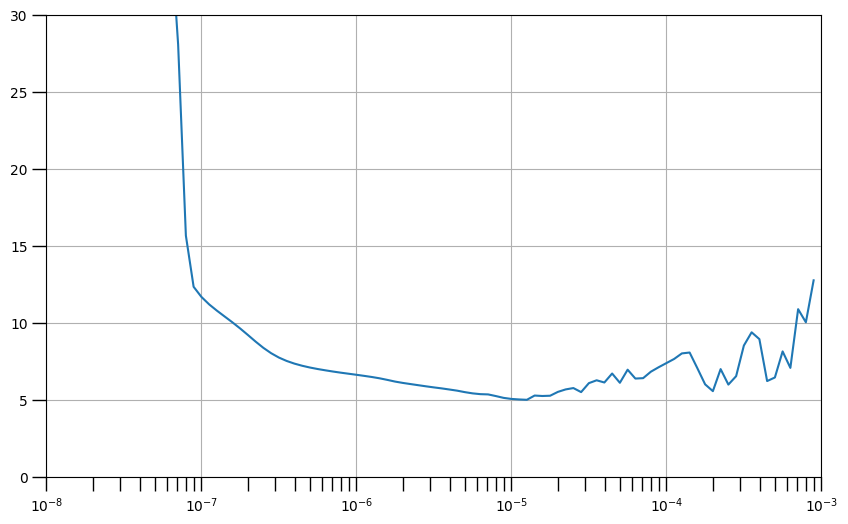

In [10]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

## Train the Model

You can then proceed to train the model with your chosen learning rate. 

*Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) method to declutter memory used by Keras. This is added in the first line below.*


In [11]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 25.0662 - mae: 25.5619
Epoch 2/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 16.2233 - mae: 16.7178

2024-10-10 10:59:45.565586: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 14.6887 - mae: 15.1814
Epoch 3/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10.7311 - mae: 11.2231

2024-10-10 10:59:46.042662: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:46.042704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:46.042710: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:46.042713: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 10:59:46.042717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:46.042721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.0919 - mae: 10.5811
Epoch 4/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.0000 - mae: 8.4872

2024-10-10 10:59:46.516999: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:46.517040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:46.517063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:46.517068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:46.517072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.6561 - mae: 8.1403
Epoch 5/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.0942 - mae: 7.5745

2024-10-10 10:59:46.937820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:46.937860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:46.937867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8450 - mae: 7.3257
Epoch 6/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.7638 - mae: 7.2479

2024-10-10 10:59:47.329282: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:47.329319: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:47.329325: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:47.329328: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 10:59:47.329333: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:47.329336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5432 - mae: 7.0247
Epoch 7/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4703 - mae: 6.9498

2024-10-10 10:59:47.721137: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:47.721178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:47.721187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:47.721190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2540 - mae: 6.7331
Epoch 8/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.3002 - mae: 6.7777

2024-10-10 10:59:48.145978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:48.146021: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0684 - mae: 6.5460
Epoch 9/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.1041 - mae: 6.5818

2024-10-10 10:59:48.593746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.9394 - mae: 6.4175
Epoch 10/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0169 - mae: 6.4959

2024-10-10 10:59:49.026711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:49.026765: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 10:59:49.026787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:49.026816: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.8268 - mae: 6.3051
Epoch 11/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.9144 - mae: 6.3943

2024-10-10 10:59:49.466858: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7287 - mae: 6.2076
Epoch 12/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.8150 - mae: 6.2959

2024-10-10 10:59:49.921274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6341 - mae: 6.1139
Epoch 13/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6628 - mae: 6.1429

2024-10-10 10:59:50.301319: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:50.301357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:50.301363: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:50.301369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:50.301372: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5450 - mae: 6.0243
Epoch 14/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5725 - mae: 6.0506

2024-10-10 10:59:50.651051: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:50.651097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:50.651104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:50.651109: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:50.651112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4569 - mae: 5.9346
Epoch 15/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4913 - mae: 5.9678

2024-10-10 10:59:51.037404: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:51.037453: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:51.037460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:51.037466: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:51.037469: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3766 - mae: 5.8536
Epoch 16/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.4498 - mae: 5.9257

2024-10-10 10:59:51.417077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:51.417123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:51.417132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3043 - mae: 5.7809
Epoch 17/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3548 - mae: 5.8298

2024-10-10 10:59:51.785712: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:51.785753: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2450 - mae: 5.7212
Epoch 18/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.3573 - mae: 5.8299

2024-10-10 10:59:52.169299: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:52.169347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:52.169353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:52.169356: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 10:59:52.169361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:52.169365: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1944 - mae: 5.6691
Epoch 19/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.2819 - mae: 5.7511

2024-10-10 10:59:52.599763: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:52.599813: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:52.599819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:52.599822: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 10:59:52.599827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:52.599830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.1496 - mae: 5.6219
Epoch 20/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2258 - mae: 5.6917

2024-10-10 10:59:53.026462: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:53.026501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:53.026507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:53.026512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:53.026515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1111 - mae: 5.5810
Epoch 21/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2024 - mae: 5.6665

2024-10-10 10:59:53.460031: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:53.460072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:53.460078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:53.460083: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:53.460087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0777 - mae: 5.5470
Epoch 22/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1562 - mae: 5.6214

2024-10-10 10:59:53.854716: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:53.854756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:53.854762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:53.854767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:53.854770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0487 - mae: 5.5184
Epoch 23/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1863 - mae: 5.6498

2024-10-10 10:59:54.269643: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:54.269677: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:54.269683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:54.269688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:54.269691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0212 - mae: 5.4905
Epoch 24/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.1648 - mae: 5.6301

2024-10-10 10:59:54.731872: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:54.731911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:54.731917: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:54.731922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:54.731927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.0006 - mae: 5.4709
Epoch 25/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0952 - mae: 5.5625

2024-10-10 10:59:55.216496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:55.216536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9765 - mae: 5.4476
Epoch 26/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1910 - mae: 5.6565

2024-10-10 10:59:55.650636: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:55.650703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:55.650711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:55.650715: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 10:59:55.650723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:55.650729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9543 - mae: 5.4256
Epoch 27/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1659 - mae: 5.6309

2024-10-10 10:59:56.105768: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:56.105818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:56.105824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:56.105826: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 10:59:56.105831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:56.105834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9304 - mae: 5.4011
Epoch 28/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0730 - mae: 5.5386

2024-10-10 10:59:56.601013: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:56.601055: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:56.601063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9113 - mae: 5.3813
Epoch 29/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.1283 - mae: 5.5925

2024-10-10 10:59:57.096667: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2024-10-10 10:59:57.096709: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:57.096716: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:57.096720: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:57.096723: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 10:59:57.096727: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:57.096731: I tensorflow/

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.8962 - mae: 5.3656
Epoch 30/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0398 - mae: 5.5061

2024-10-10 10:59:57.610799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8791 - mae: 5.3494
Epoch 31/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9722 - mae: 5.4395

2024-10-10 10:59:58.060582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:58.060633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:58.060656: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:58.060673: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8659 - mae: 5.3363
Epoch 32/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.1162 - mae: 5.5819

2024-10-10 10:59:58.533160: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:58.533205: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:58.533211: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:58.533214: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 10:59:58.533219: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:58.533222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.8541 - mae: 5.3244
Epoch 33/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9844 - mae: 5.4511

2024-10-10 10:59:59.042128: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:59.042168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:59.042173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:59.042176: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 10:59:59.042180: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:59.042183: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8426 - mae: 5.3125
Epoch 34/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.9874 - mae: 5.4547

2024-10-10 10:59:59.471257: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:59.471296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:59.471302: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:59.471307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:59.471310: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8278 - mae: 5.2979
Epoch 35/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9576 - mae: 5.4246

2024-10-10 10:59:59.937595: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 10:59:59.937637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 10:59:59.937642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 10:59:59.937647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 10:59:59.937650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8160 - mae: 5.2857
Epoch 36/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9446 - mae: 5.4113

2024-10-10 11:00:00.409891: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:00.409945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:00.409950: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:00.409956: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:00.409959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8020 - mae: 5.2714
Epoch 37/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9080 - mae: 5.3755

2024-10-10 11:00:00.858768: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:00.858810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:00.858816: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:00.858821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:00.858824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7863 - mae: 5.2559
Epoch 38/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8624 - mae: 5.3304

2024-10-10 11:00:01.282391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7702 - mae: 5.2398
Epoch 39/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8779 - mae: 5.3466

2024-10-10 11:00:01.638176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:01.638215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7573 - mae: 5.2274
Epoch 40/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8812 - mae: 5.3510

2024-10-10 11:00:02.046542: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:02.046576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:02.046581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:02.046586: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:02.046589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7421 - mae: 5.2126
Epoch 41/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9173 - mae: 5.3882

2024-10-10 11:00:02.469210: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:02.469252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:02.469257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:02.469260: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:02.469265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:02.469268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7289 - mae: 5.2002
Epoch 42/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8316 - mae: 5.3030

2024-10-10 11:00:02.935426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:02.935465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:02.935473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7151 - mae: 5.1866
Epoch 43/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8872 - mae: 5.3600

2024-10-10 11:00:03.352640: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:03.352684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:03.352689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:03.352692: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:03.352697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:03.352700: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7027 - mae: 5.1750
Epoch 44/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8051 - mae: 5.2783

2024-10-10 11:00:03.773186: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:03.773224: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:03.773230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:03.773232: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:03.773236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:03.773240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6911 - mae: 5.1640
Epoch 45/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7931 - mae: 5.2665

2024-10-10 11:00:04.164845: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:04.164890: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:04.164897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:04.164901: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:04.164907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:04.164912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6799 - mae: 5.1529
Epoch 46/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7826 - mae: 5.2551

2024-10-10 11:00:04.575736: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6699 - mae: 5.1423
Epoch 47/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7904 - mae: 5.2621

2024-10-10 11:00:04.989494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:04.989540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:04.989550: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:04.989554: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6608 - mae: 5.1327
Epoch 48/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7229 - mae: 5.1935

2024-10-10 11:00:05.425593: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:05.425641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:05.425648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:05.425654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:05.425658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6526 - mae: 5.1238
Epoch 49/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7532 - mae: 5.2230

2024-10-10 11:00:05.797116: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:05.797157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:05.797162: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:05.797168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:05.797171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6444 - mae: 5.1151
Epoch 50/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7261 - mae: 5.1956

2024-10-10 11:00:06.191268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:06.191326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6413 - mae: 5.1116
Epoch 51/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7329 - mae: 5.2025

2024-10-10 11:00:06.564214: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:06.564255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:06.564262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:06.564264: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:06.564270: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:06.564273: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6351 - mae: 5.1056
Epoch 52/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7397 - mae: 5.2095

2024-10-10 11:00:06.976366: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:06.976412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:06.976419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:06.976422: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:06.976427: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:06.976430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6314 - mae: 5.1018
Epoch 53/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7121 - mae: 5.1817

2024-10-10 11:00:07.383557: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:07.383604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:07.383611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:07.383616: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:07.383619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6282 - mae: 5.0986
Epoch 54/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7221 - mae: 5.1923

2024-10-10 11:00:07.778419: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:07.778461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:07.778467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:07.778472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:07.778476: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6244 - mae: 5.0951
Epoch 55/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7038 - mae: 5.1742

2024-10-10 11:00:08.160454: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:08.160493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:08.160499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:08.160502: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:08.160506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:08.160510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6205 - mae: 5.0914
Epoch 56/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7030 - mae: 5.1735

2024-10-10 11:00:08.526280: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:08.526321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:08.526327: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:08.526332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:08.526335: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6187 - mae: 5.0896
Epoch 57/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7133 - mae: 5.1839

2024-10-10 11:00:08.917353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6154 - mae: 5.0864
Epoch 58/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6977 - mae: 5.1685

2024-10-10 11:00:09.310869: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:09.310907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:09.310913: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:09.310918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:09.310921: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6135 - mae: 5.0846
Epoch 59/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7170 - mae: 5.1883

2024-10-10 11:00:09.685808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6091 - mae: 5.0806
Epoch 60/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6752 - mae: 5.1466

2024-10-10 11:00:10.056608: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:10.056650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:10.056656: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:10.056661: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:10.056664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6061 - mae: 5.0778
Epoch 61/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6901 - mae: 5.1612

2024-10-10 11:00:10.376501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:10.376541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6062 - mae: 5.0776
Epoch 62/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7145 - mae: 5.1857

2024-10-10 11:00:10.746514: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:10.746557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:10.746563: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:10.746566: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:10.746570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:10.746574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6056 - mae: 5.0770
Epoch 63/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7324 - mae: 5.2035

2024-10-10 11:00:11.144016: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:11.144066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:11.144073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:11.144095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:11.144099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6063 - mae: 5.0776
Epoch 64/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6926 - mae: 5.1635

2024-10-10 11:00:11.539336: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:11.539376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:11.539382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:11.539385: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:11.539389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:11.539392: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6063 - mae: 5.0775
Epoch 65/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7285 - mae: 5.2000

2024-10-10 11:00:11.907506: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:11.907547: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:11.907553: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:11.907558: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:11.907562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6027 - mae: 5.0741
Epoch 66/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7034 - mae: 5.1748

2024-10-10 11:00:12.330837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:12.330875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:12.330882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:12.330886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6032 - mae: 5.0749
Epoch 67/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6901 - mae: 5.1616

2024-10-10 11:00:12.724343: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:12.724386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:12.724392: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:12.724397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:12.724401: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6035 - mae: 5.0752
Epoch 68/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6901 - mae: 5.1620

2024-10-10 11:00:13.123410: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:13.123461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:13.123470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:13.123475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:13.123478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6030 - mae: 5.0749
Epoch 69/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7027 - mae: 5.1746

2024-10-10 11:00:13.477265: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:13.477305: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:13.477311: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:13.477316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:13.477320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6018 - mae: 5.0737
Epoch 70/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7021 - mae: 5.1746

2024-10-10 11:00:13.854562: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:13.854602: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:13.854608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:13.854613: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:13.854616: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6011 - mae: 5.0734
Epoch 71/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7054 - mae: 5.1783

2024-10-10 11:00:14.253378: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:14.253420: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:14.253426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:14.253431: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:14.253434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6029 - mae: 5.0754
Epoch 72/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7031 - mae: 5.1760

2024-10-10 11:00:14.658629: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:14.658670: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:14.658677: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:14.658680: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:14.658684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:14.658688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6017 - mae: 5.0742
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6029 - mae: 5.0756
Epoch 74/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6938 - mae: 5.1672

2024-10-10 11:00:15.453152: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:15.453196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:15.453202: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:15.453205: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:15.453209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:15.453212: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6042 - mae: 5.0770
Epoch 75/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7565 - mae: 5.2306

2024-10-10 11:00:15.805858: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:15.805901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.6021 - mae: 5.0748
Epoch 76/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7174 - mae: 5.1911

2024-10-10 11:00:16.302703: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:16.302744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:16.302750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:16.302756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:16.302759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6029 - mae: 5.0755
Epoch 77/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7187 - mae: 5.1924

2024-10-10 11:00:16.715450: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:16.715488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:16.715494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:16.715497: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:16.715501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:16.715504: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6031 - mae: 5.0757
Epoch 78/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7183 - mae: 5.1920

2024-10-10 11:00:17.125381: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:17.125422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:17.125429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:17.125432: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:17.125436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:17.125439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6025 - mae: 5.0751
Epoch 79/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7315 - mae: 5.2052

2024-10-10 11:00:17.571714: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:17.571758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:17.571764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:17.571769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:17.571773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.6005 - mae: 5.0731
Epoch 80/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7135 - mae: 5.1870

2024-10-10 11:00:18.051354: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:18.051398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:18.051405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:18.051407: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:18.051412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:18.051415: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5981 - mae: 5.0707
Epoch 81/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7255 - mae: 5.1990

2024-10-10 11:00:18.496560: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:18.496601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:18.496607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:18.496610: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:18.496614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:18.496619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.5965 - mae: 5.0690
Epoch 82/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7306 - mae: 5.2042

2024-10-10 11:00:18.967099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5989 - mae: 5.0715
Epoch 83/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7143 - mae: 5.1878

2024-10-10 11:00:19.396824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:19.396869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:19.396876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:19.396879: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5989 - mae: 5.0715
Epoch 84/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.7419 - mae: 5.2157

2024-10-10 11:00:19.844699: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:19.844750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:19.844756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:19.844759: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:19.844763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:19.844766: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.5978 - mae: 5.0706
Epoch 85/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7038 - mae: 5.1776

2024-10-10 11:00:20.314754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:20.314796: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5985 - mae: 5.0715
Epoch 86/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6922 - mae: 5.1664

2024-10-10 11:00:20.719039: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:20.719093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:20.719101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:20.719789: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:20.719976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:20.720028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6001 - mae: 5.0734
Epoch 87/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6921 - mae: 5.1665

2024-10-10 11:00:21.090410: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:21.090576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:21.091053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:21.091278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:21.091354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5995 - mae: 5.0730
Epoch 88/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6887 - mae: 5.1629

2024-10-10 11:00:21.454164: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:21.454207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:21.454214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:21.454217: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:21.454222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:21.454225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5970 - mae: 5.0704
Epoch 89/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7441 - mae: 5.2188

2024-10-10 11:00:21.809882: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:21.809922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:21.809929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:21.809935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:21.809940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5979 - mae: 5.0713
Epoch 90/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7141 - mae: 5.1886

2024-10-10 11:00:22.216157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5966 - mae: 5.0700
Epoch 91/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6878 - mae: 5.1621

2024-10-10 11:00:22.612807: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:22.612853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:22.612861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:22.612865: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:22.612872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:22.612877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5955 - mae: 5.0688
Epoch 92/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7243 - mae: 5.1985

2024-10-10 11:00:22.963708: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:22.963754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:22.963762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:22.964355: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:22.964527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:22.964561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5930 - mae: 5.0664
Epoch 93/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7063 - mae: 5.1802

2024-10-10 11:00:23.379141: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:23.379823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:23.379981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:23.380123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:23.380156: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5911 - mae: 5.0644
Epoch 94/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6943 - mae: 5.1682

2024-10-10 11:00:23.776057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5896 - mae: 5.0630
Epoch 95/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7200 - mae: 5.1937

2024-10-10 11:00:24.179184: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5894 - mae: 5.0626
Epoch 96/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6962 - mae: 5.1700

2024-10-10 11:00:24.595664: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:24.595707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:24.595716: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:24.595720: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:24.596338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:24.596388: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5907 - mae: 5.0641
Epoch 97/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7065 - mae: 5.1806

2024-10-10 11:00:24.973243: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:24.973288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:24.973296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:24.973300: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:24.974011: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:24.974224: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5908 - mae: 5.0643
Epoch 98/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6958 - mae: 5.1700

2024-10-10 11:00:25.357842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:25.357882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5903 - mae: 5.0639
Epoch 99/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6793 - mae: 5.1536

2024-10-10 11:00:25.750111: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:25.750155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:25.750163: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:25.750167: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:25.750174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:25.750178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5881 - mae: 5.0618
Epoch 100/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7161 - mae: 5.1901

2024-10-10 11:00:26.133982: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:26.134023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:26.134031: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:26.134035: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:26.134042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:26.134047: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5860 - mae: 5.0595


2024-10-10 11:00:26.563563: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433


## Model Prediction

You will then generate batches of windows to generate predictions that align with the validation set.

In [12]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

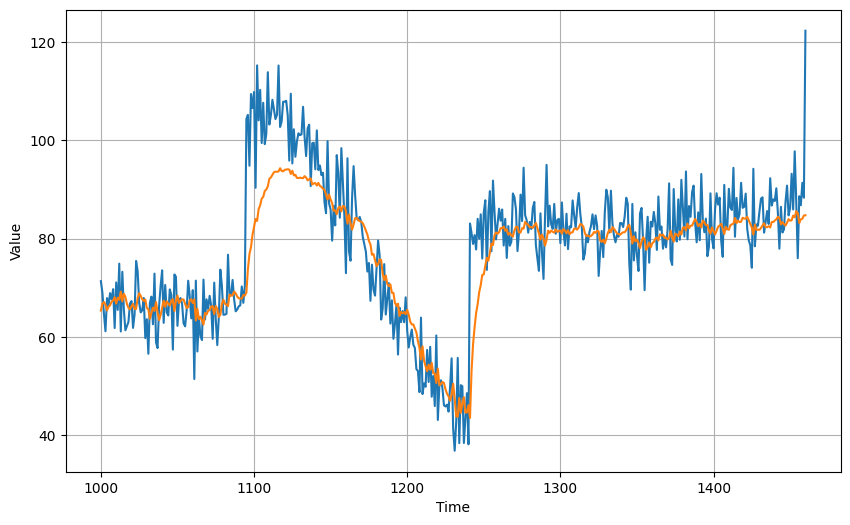

In [13]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then generate the metrics to evaluate the model's performance.

In [14]:
# Compute the MSE and MAE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

64.745636
5.741382


## Wrap Up

This concludes this short exercise on using LSTMs for time series forecasting. Next week, you will build upon this and add convolutions. Then, you will start to move away from synthetic data and use real-world datasets. See you there!

## Optional: Including a Validation Set while Training

Back in the first course of this specialization, you saw how you can also monitor the performance of your model against a validation set while training. You can also do that for this lab. 

First, you need to generate a `val_set` which are data windows and labels that your model can accept. You can simply reuse the `windowed_dataset` function for that and you can pass in the `x_valid` points to generate the windows.

In [15]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

You can then do the same training as before but pass in the `val_set` to the `validation_data` parameter of the `fit()` method.

In [16]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
     31/Unknown 2s 16ms/step - loss: 29.6382 - mae: 30.1366

2024-10-10 11:00:29.010044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:29.010090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:29.010098: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:29.010102: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 29.3769 - mae: 29.8753 - val_loss: 21.4389 - val_mae: 21.9368
Epoch 2/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 11.9779 - mae: 12.4728

2024-10-10 11:00:29.383724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:29.383781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:29.383789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 10.5802 - mae: 11.0719 - val_loss: 17.5374 - val_mae: 18.0348
Epoch 3/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.1044 - mae: 9.5975 

2024-10-10 11:00:29.861225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:29.861277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:29.861286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:29.861290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:29.952161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:29.952216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:29.952223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.1046 - mae: 8.5937 - val_loss: 15.5743 - val_mae: 16.0678
Epoch 4/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4937 - mae: 8.9760

2024-10-10 11:00:30.377651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:30.377694: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:30.377703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:30.377706: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:30.469513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:30.469551: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:30.469557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.5016 - mae: 7.9834 - val_loss: 14.5246 - val_mae: 15.0185
Epoch 5/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.0046 - mae: 8.4934

2024-10-10 11:00:30.931398: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:30.931440: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:30.931446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:30.931449: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:30.931454: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:30.931458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:31.017025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.2058 - mae: 7.6885 - val_loss: 13.7553 - val_mae: 14.2478
Epoch 6/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.8131 - mae: 8.2936

2024-10-10 11:00:31.411095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:31.411138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:31.411145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:31.411149: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:31.500205: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:31.500255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:31.500261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.0231 - mae: 7.5026 - val_loss: 13.0863 - val_mae: 13.5751
Epoch 7/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.8174 - mae: 8.2980

2024-10-10 11:00:31.903481: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:31.903521: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:31.903529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:31.903532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:31.996210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:31.996246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:31.996252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.8988 - mae: 7.3778 - val_loss: 12.5978 - val_mae: 13.0891
Epoch 8/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.5382 - mae: 8.0176

2024-10-10 11:00:32.414570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:32.414610: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:32.414618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:32.414621: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:32.499245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:32.499289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:32.499295: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.7921 - mae: 7.2712 - val_loss: 12.2268 - val_mae: 12.7194
Epoch 9/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4295 - mae: 7.9079

2024-10-10 11:00:32.888269: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:32.888316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:32.888324: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:32.888327: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:32.971508: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:32.971550: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:32.971555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.6978 - mae: 7.1770 - val_loss: 11.9039 - val_mae: 12.3968
Epoch 10/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4718 - mae: 7.9505

2024-10-10 11:00:33.364468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:33.364507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:33.364514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:33.364518: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:33.462538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:33.462587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:33.462593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.6116 - mae: 7.0915 - val_loss: 11.6434 - val_mae: 12.1370
Epoch 11/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.2350 - mae: 7.7128

2024-10-10 11:00:33.895595: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:33.895636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:33.895641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:33.895644: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:33.895650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:33.895653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:33.992588: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.5304 - mae: 7.0100 - val_loss: 11.4113 - val_mae: 11.9046
Epoch 12/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1502 - mae: 7.6275

2024-10-10 11:00:34.430662: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:34.430734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:34.430743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:34.430747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:34.515609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.4561 - mae: 6.9354 - val_loss: 11.1833 - val_mae: 11.6767
Epoch 13/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0707 - mae: 7.5471

2024-10-10 11:00:34.912045: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:34.912091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:34.912097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:34.912100: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:34.912106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:34.912109: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:35.005316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.3867 - mae: 6.8659 - val_loss: 10.9712 - val_mae: 11.4654
Epoch 14/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1314 - mae: 7.6073

2024-10-10 11:00:35.381187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:35.381225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:35.381233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:35.381236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:35.456880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:35.456924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:35.456930: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3235 - mae: 6.8027 - val_loss: 10.7967 - val_mae: 11.2908
Epoch 15/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.9300 - mae: 7.4050

2024-10-10 11:00:35.859426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:35.859475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:35.859484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:35.859487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:35.936784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:35.936820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:35.936826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.2623 - mae: 6.7408 - val_loss: 10.6091 - val_mae: 11.1024
Epoch 16/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8656 - mae: 7.3395

2024-10-10 11:00:36.350654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:36.350695: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:36.350704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:36.350707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:36.429681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:36.429730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:36.429736: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.2042 - mae: 6.6817 - val_loss: 10.4114 - val_mae: 10.9041
Epoch 17/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9283 - mae: 7.4004

2024-10-10 11:00:36.986391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:36.986429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:36.986438: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:36.986442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:37.078629: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:37.078679: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:37.078687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.1480 - mae: 6.6251 - val_loss: 10.2290 - val_mae: 10.7225
Epoch 18/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.8654 - mae: 7.3364

2024-10-10 11:00:37.533978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:37.534026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:37.534034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:37.534039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:37.640472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:37.640526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:37.640532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.0949 - mae: 6.5713 - val_loss: 10.0386 - val_mae: 10.5326
Epoch 19/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8036 - mae: 7.2785

2024-10-10 11:00:38.091139: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:38.091188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:38.091195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:38.091198: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:38.091203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:38.091206: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:38.184004: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.0428 - mae: 6.5207 - val_loss: 9.8781 - val_mae: 10.3729
Epoch 20/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6265 - mae: 7.1050

2024-10-10 11:00:38.617601: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:38.617644: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:38.617650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:38.617652: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:38.617657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:38.617661: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:38.709104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.9941 - mae: 6.4736 - val_loss: 9.7327 - val_mae: 10.2272
Epoch 21/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6923 - mae: 7.1723

2024-10-10 11:00:39.102676: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:39.102739: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:39.102744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:39.102765: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:39.185523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:39.185570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:39.185576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.9473 - mae: 6.4271 - val_loss: 9.5837 - val_mae: 10.0772
Epoch 22/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6418 - mae: 7.1234

2024-10-10 11:00:39.609664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:39.609707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:39.609715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:39.609719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:39.699060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:39.699109: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:39.699115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.9034 - mae: 6.3837 - val_loss: 9.4379 - val_mae: 9.9305
Epoch 23/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.5927 - mae: 7.0769

2024-10-10 11:00:40.181328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:40.181384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:40.181389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:40.181408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:40.280007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:40.280052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:40.280057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.8612 - mae: 6.3424 - val_loss: 9.3109 - val_mae: 9.8037
Epoch 24/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5459 - mae: 7.0315

2024-10-10 11:00:40.718093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:40.718140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:40.718148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:40.718152: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:40.801700: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:40.801748: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:40.801754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.8204 - mae: 6.3015 - val_loss: 9.1901 - val_mae: 9.6825
Epoch 25/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5009 - mae: 6.9874

2024-10-10 11:00:41.261514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:41.261584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:41.261615: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:41.261619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:41.357318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:41.357363: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:41.357370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.7807 - mae: 6.2620 - val_loss: 9.0688 - val_mae: 9.5605
Epoch 26/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4557 - mae: 6.9425

2024-10-10 11:00:41.773955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:41.774003: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:41.774013: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:41.774017: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:41.873534: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:41.873574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:41.873580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.7409 - mae: 6.2224 - val_loss: 8.9372 - val_mae: 9.4279
Epoch 27/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.4099 - mae: 6.8960

2024-10-10 11:00:42.299780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:42.299825: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:42.299834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:42.299838: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:42.402368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:42.402429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:42.402437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.7004 - mae: 6.1820 - val_loss: 8.8056 - val_mae: 9.2952
Epoch 28/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.3649 - mae: 6.8499

2024-10-10 11:00:42.888610: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:42.888649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:42.888655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:42.888658: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:42.888663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:42.888666: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:42.984813: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.6622 - mae: 6.1434 - val_loss: 8.6816 - val_mae: 9.1712
Epoch 29/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2173 - mae: 6.7001

2024-10-10 11:00:43.411654: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:43.411696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:43.411703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:43.411705: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:43.411711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:43.411715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:43.501406: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is a

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.6244 - mae: 6.1047 - val_loss: 8.5562 - val_mae: 9.0455
Epoch 30/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2726 - mae: 6.7539

2024-10-10 11:00:43.965283: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:43.965333: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:43.965342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:43.965346: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:43.965369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:43.965374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:44.049330: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.5848 - mae: 6.0645 - val_loss: 8.4670 - val_mae: 8.9559
Epoch 31/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2254 - mae: 6.7052

2024-10-10 11:00:44.476445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:44.476488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:44.476496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:44.476500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:44.572684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:44.572728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:44.572735: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.5457 - mae: 6.0248 - val_loss: 8.3681 - val_mae: 8.8567
Epoch 32/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.1790 - mae: 6.6574

2024-10-10 11:00:45.016893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:45.016937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:45.016946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:45.016949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:45.110866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:45.110917: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:45.110924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.5078 - mae: 5.9859 - val_loss: 8.2768 - val_mae: 8.7646
Epoch 33/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0375 - mae: 6.5167

2024-10-10 11:00:45.544659: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:45.544709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:45.544717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:45.544722: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:45.544728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:45.544732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:45.636663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.4691 - mae: 5.9472 - val_loss: 8.1765 - val_mae: 8.6629
Epoch 34/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0810 - mae: 6.5621

2024-10-10 11:00:46.031022: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:46.031073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:46.031079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:46.031084: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:46.031091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:46.031097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:46.113749: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.4303 - mae: 5.9092 - val_loss: 8.0898 - val_mae: 8.5750
Epoch 35/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9445 - mae: 6.4253

2024-10-10 11:00:46.524741: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:46.524788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:46.524794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:46.524798: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:46.524817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:46.524821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:46.599968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.3936 - mae: 5.8730 - val_loss: 8.0042 - val_mae: 8.4879
Epoch 36/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.9856 - mae: 6.4669

2024-10-10 11:00:47.013492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:47.013539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:47.013549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:47.013555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:47.109417: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:47.109462: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:47.109467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3578 - mae: 5.8371 - val_loss: 7.9388 - val_mae: 8.4217
Epoch 37/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.9383 - mae: 6.4209

2024-10-10 11:00:47.525806: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:47.525849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:47.525857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:47.525861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:47.623955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:47.624001: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:47.624006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.3226 - mae: 5.8018 - val_loss: 7.8832 - val_mae: 8.3658
Epoch 38/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.8931 - mae: 6.3779

2024-10-10 11:00:48.029348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:48.029398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:48.029407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:48.029411: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:48.126856: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:48.126901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:48.126907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.2894 - mae: 5.7692 - val_loss: 7.8178 - val_mae: 8.3003
Epoch 39/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.8482 - mae: 6.3345

2024-10-10 11:00:48.535433: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:48.535486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:48.535494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:48.535498: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:48.535505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:48.535510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:48.627727: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2579 - mae: 5.7379 - val_loss: 7.7722 - val_mae: 8.2552
Epoch 40/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7298 - mae: 6.2158

2024-10-10 11:00:49.060010: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:49.060053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:49.060060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:49.060063: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:49.060068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:49.060072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:49.146023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.2281 - mae: 5.7084 - val_loss: 7.7402 - val_mae: 8.2234
Epoch 41/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7644 - mae: 6.2512

2024-10-10 11:00:49.588244: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:49.588304: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:49.588312: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:49.588316: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:49.588323: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:49.588328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:49.694653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.1991 - mae: 5.6796 - val_loss: 7.6848 - val_mae: 8.1679
Epoch 42/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.7260 - mae: 6.2122

2024-10-10 11:00:50.170057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:50.170106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:50.170113: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:50.170120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:50.170123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:50.267105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:50.267155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.1722 - mae: 5.6524 - val_loss: 7.6764 - val_mae: 8.1599
Epoch 43/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.6890 - mae: 6.1756

2024-10-10 11:00:50.696752: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:50.696810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:50.696818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:50.696822: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:50.696829: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:50.696834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:50.793593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.1473 - mae: 5.6279 - val_loss: 7.6500 - val_mae: 8.1333
Epoch 44/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5867 - mae: 6.0733

2024-10-10 11:00:51.242579: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:51.242627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:51.242635: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:51.242640: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:51.242648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:51.242653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:51.328410: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.1233 - mae: 5.6047 - val_loss: 7.6146 - val_mae: 8.0977
Epoch 45/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.3945 - mae: 6.8913

2024-10-10 11:00:51.733442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:51.733528: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:51.733543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:51.733549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:51.852837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.1004 - mae: 5.5825 - val_loss: 7.5691 - val_mae: 8.0517
Epoch 46/100
 4/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.6827 - mae: 6.1728

2024-10-10 11:00:52.307544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:52.307589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:52.307599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:52.307603: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:52.411412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:52.411467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:52.411473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.0783 - mae: 5.5609 - val_loss: 7.5303 - val_mae: 8.0127
Epoch 47/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5563 - mae: 6.0445

2024-10-10 11:00:52.922640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:52.922685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:52.922693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:52.922697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:53.020071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:53.020122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:53.020128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.0566 - mae: 5.5395 - val_loss: 7.4858 - val_mae: 7.9682
Epoch 48/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.5258 - mae: 6.0143

2024-10-10 11:00:53.483797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:53.483841: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:53.483849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:53.483853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:53.568675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:53.568719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:53.568726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0357 - mae: 5.5186 - val_loss: 7.4421 - val_mae: 7.9247
Epoch 49/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4372 - mae: 5.9244

2024-10-10 11:00:53.997463: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:53.997516: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:53.997524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:53.997528: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:53.997535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:53.997541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:54.078535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0159 - mae: 5.4984 - val_loss: 7.3797 - val_mae: 7.8621
Epoch 50/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4099 - mae: 5.8966

2024-10-10 11:00:54.476717: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:54.476769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:54.476778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:54.476782: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:54.476789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:54.476795: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:54.560338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.9961 - mae: 5.4778 - val_loss: 7.3120 - val_mae: 7.7939
Epoch 51/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3850 - mae: 5.8706

2024-10-10 11:00:54.948212: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:54.948254: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:54.948260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:54.948263: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:54.948268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:54.948272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:55.025436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9773 - mae: 5.4582 - val_loss: 7.2463 - val_mae: 7.7280
Epoch 52/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4164 - mae: 5.9010

2024-10-10 11:00:55.425017: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:55.425066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:55.425073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:55.425077: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:55.425115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:55.425122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:55.517979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.9593 - mae: 5.4388 - val_loss: 7.1988 - val_mae: 7.6805
Epoch 53/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3384 - mae: 5.8212

2024-10-10 11:00:55.973242: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:55.973290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:55.973297: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:55.973300: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:55.973307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:55.973311: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:56.064887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.9423 - mae: 5.4210 - val_loss: 7.1224 - val_mae: 7.6040
Epoch 54/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3730 - mae: 5.8577

2024-10-10 11:00:56.519339: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:56.519386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:56.519395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:56.519399: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:56.625058: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:56.625091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:56.625097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.9277 - mae: 5.4061 - val_loss: 7.0661 - val_mae: 7.5475
Epoch 55/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.0901 - mae: 6.5885

2024-10-10 11:00:57.121444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:57.121494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:57.121502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:57.121506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:57.237020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:57.237069: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:57.237077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.9138 - mae: 5.3923 - val_loss: 7.0023 - val_mae: 7.4837
Epoch 56/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.0706 - mae: 6.5686

2024-10-10 11:00:57.773373: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:00:57.773428: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:57.773437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:57.773440: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:00:57.773449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:57.773453: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:57.896790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.9009 - mae: 5.3794 - val_loss: 6.9500 - val_mae: 7.4318
Epoch 57/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.0503 - mae: 6.5483

2024-10-10 11:00:58.500569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:58.500626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:58.500638: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:58.500644: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:58.620989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:58.621039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:58.621046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.8885 - mae: 5.3666 - val_loss: 6.9020 - val_mae: 7.3841
Epoch 58/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.0295 - mae: 6.5274

2024-10-10 11:00:59.391238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:00:59.391296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:00:59.391305: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:00:59.391309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:00:59.513897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:00:59.513939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:00:59.513945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.8757 - mae: 5.3534 - val_loss: 6.8384 - val_mae: 7.3204
Epoch 59/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2952 - mae: 5.7790

2024-10-10 11:01:00.030080: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:01:00.030124: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:00.030132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:00.030135: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:01:00.030141: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:00.030145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:00.134893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.8654 - mae: 5.3424 - val_loss: 6.7841 - val_mae: 7.2659
Epoch 60/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2842 - mae: 5.7672

2024-10-10 11:01:00.579981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:00.580026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:00.580035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:00.580039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:00.678884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:00.678940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:00.678947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.8564 - mae: 5.3331 - val_loss: 6.7287 - val_mae: 7.2102
Epoch 61/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.2245 - mae: 5.7061

2024-10-10 11:01:01.218121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:01.218164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:01.218172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:01.218176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:01.310324: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:01.310376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:01.310382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.8472 - mae: 5.3240 - val_loss: 6.6628 - val_mae: 7.1432
Epoch 62/100
 4/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.3339 - mae: 5.8171

2024-10-10 11:01:01.754811: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:01:01.754855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:01.754861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:01.754864: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:01:01.754869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:01.754875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:01.845387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.8400 - mae: 5.3169 - val_loss: 6.5921 - val_mae: 7.0713
Epoch 63/100
 4/31 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.3243 - mae: 5.8056

2024-10-10 11:01:02.392230: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:01:02.392271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:02.392278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:02.392280: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:01:02.392285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:02.392289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:02.474759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.8349 - mae: 5.3115 - val_loss: 6.5374 - val_mae: 7.0159
Epoch 64/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2454 - mae: 5.7237

2024-10-10 11:01:02.946278: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:01:02.946322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:02.946329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:02.946332: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:01:02.946338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:02.946342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:03.043524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.8278 - mae: 5.3040 - val_loss: 6.4879 - val_mae: 6.9657
Epoch 65/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.9302 - mae: 6.4223

2024-10-10 11:01:03.555303: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:03.555369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:03.555382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:03.670059: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:03.670107: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:03.670113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.8219 - mae: 5.2975 - val_loss: 6.4106 - val_mae: 6.8883
Epoch 66/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.9224 - mae: 6.4110

2024-10-10 11:01:04.263582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:04.263631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:04.263639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:04.263643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:04.394587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:04.394649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:04.394657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.8164 - mae: 5.2921 - val_loss: 6.3711 - val_mae: 6.8494
Epoch 67/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.9098 - mae: 6.3975

2024-10-10 11:01:04.963763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:04.963820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:05.066612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:05.066658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:05.066664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.8094 - mae: 5.2850 - val_loss: 6.3291 - val_mae: 6.8081
Epoch 68/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2052 - mae: 5.6812

2024-10-10 11:01:05.563535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:05.665482: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:05.665525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:05.665531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.8013 - mae: 5.2767 - val_loss: 6.3024 - val_mae: 6.7815
Epoch 69/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.8774 - mae: 6.3643

2024-10-10 11:01:06.143640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:06.143691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:06.143701: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:06.143705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:06.252594: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:06.252647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:06.252653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7909 - mae: 5.2662 - val_loss: 6.2583 - val_mae: 6.7379
Epoch 70/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1808 - mae: 5.6557

2024-10-10 11:01:06.807271: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:01:06.807330: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:06.807334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:06.807372: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:06.807417: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:06.904573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:06.904621: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous rec

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7852 - mae: 5.2600 - val_loss: 6.2342 - val_mae: 6.7140
Epoch 71/100


2024-10-10 11:01:07.400020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:07.400094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:07.400110: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:07.400115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:07.557705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:07.557772: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7776 - mae: 5.2523 - val_loss: 6.2064 - val_mae: 6.6865
Epoch 72/100
 4/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.2137 - mae: 5.6891

2024-10-10 11:01:08.103263: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:08.103312: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:08.103323: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:08.103328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:08.205590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:08.205639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:08.205645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.7698 - mae: 5.2444 - val_loss: 6.1800 - val_mae: 6.6605
Epoch 73/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.8218 - mae: 6.3051

2024-10-10 11:01:08.796261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:08.796308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:08.796316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:08.796320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:08.900545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:08.900605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:08.900612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.7638 - mae: 5.2381 - val_loss: 6.1703 - val_mae: 6.6507
Epoch 74/100


2024-10-10 11:01:09.520242: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:09.689617: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:09.689665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:09.689673: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.7541 - mae: 5.2286 - val_loss: 6.1576 - val_mae: 6.6379
Epoch 75/100


2024-10-10 11:01:10.338373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:10.338449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:10.338463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:10.338468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:10.499269: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:10.499362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:10.499372: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.7472 - mae: 5.2217 - val_loss: 6.1092 - val_mae: 6.5903
Epoch 76/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.7778 - mae: 6.2593

2024-10-10 11:01:11.143532: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:01:11.143590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:11.143597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:11.143600: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:01:11.143617: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:11.143623: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:11.269980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.7438 - mae: 5.2175 - val_loss: 6.0975 - val_mae: 6.5786
Epoch 77/100


2024-10-10 11:01:11.884478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:11.884549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:11.884565: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:11.884572: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:12.046916: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:12.046979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:12.046986: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7358 - mae: 5.2097 - val_loss: 6.1084 - val_mae: 6.5888
Epoch 78/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.7383 - mae: 6.2243

2024-10-10 11:01:12.593578: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:12.593667: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:12.593683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:12.593689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:12.710266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:12.710352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:12.710361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.7261 - mae: 5.2005 - val_loss: 6.0929 - val_mae: 6.5731
Epoch 79/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.7233 - mae: 6.2097

2024-10-10 11:01:13.301843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:13.301969: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:13.301995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:13.302003: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:13.437875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:13.437958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:13.437968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.7186 - mae: 5.1927 - val_loss: 6.0877 - val_mae: 6.5675
Epoch 80/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.7067 - mae: 6.1945

2024-10-10 11:01:14.074839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:14.074901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:14.074911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:14.216998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:14.217072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:14.217081: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4.7099 - mae: 5.1843 - val_loss: 6.0989 - val_mae: 6.5777
Epoch 81/100
 4/31 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.0840 - mae: 5.5604

2024-10-10 11:01:15.259176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:15.259259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:15.259269: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.7011 - mae: 5.1757 - val_loss: 6.0941 - val_mae: 6.5724
Epoch 82/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.6690 - mae: 6.1606

2024-10-10 11:01:15.918608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:16.052797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:16.052874: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:16.052884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6937 - mae: 5.1686 - val_loss: 6.0771 - val_mae: 6.5557
Epoch 83/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9825 - mae: 5.4562

2024-10-10 11:01:16.521769: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:01:16.521823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:16.521830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:16.521833: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:01:16.521838: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:16.521842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:16.614201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6872 - mae: 5.1621 - val_loss: 6.0552 - val_mae: 6.5344
Epoch 84/100
 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9725 - mae: 5.4458

2024-10-10 11:01:17.092746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:17.092819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:17.183934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:17.183989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:17.183995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6812 - mae: 5.1559 - val_loss: 6.0372 - val_mae: 6.5167
Epoch 85/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.6313 - mae: 6.1227

2024-10-10 11:01:17.634033: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:17.634086: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:17.634095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:17.634101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:17.725511: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.6747 - mae: 5.1493 - val_loss: 6.0068 - val_mae: 6.4871
Epoch 86/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9869 - mae: 5.4598

2024-10-10 11:01:18.217863: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:18.217919: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:18.217929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:18.217933: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:18.299217: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:18.299280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.6708 - mae: 5.1442 - val_loss: 5.9819 - val_mae: 6.4627
Epoch 87/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.6118 - mae: 6.1016

2024-10-10 11:01:18.832872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:18.832969: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:18.976299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:18.976405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:18.976413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.6651 - mae: 5.1382 - val_loss: 5.9683 - val_mae: 6.4491
Epoch 88/100


2024-10-10 11:01:19.637384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:19.637476: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:19.637492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:19.797113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:19.797186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:19.797194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.6595 - mae: 5.1322 - val_loss: 5.9400 - val_mae: 6.4211
Epoch 89/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.5924 - mae: 6.0813

2024-10-10 11:01:20.486139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:20.486203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:20.486217: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:20.486224: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:20.625209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:20.625267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:20.625274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.6546 - mae: 5.1266 - val_loss: 5.9304 - val_mae: 6.4113
Epoch 90/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.5802 - mae: 6.0695

2024-10-10 11:01:21.290559: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:21.290619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:21.290631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:21.401295: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:21.401361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:21.401368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.6490 - mae: 5.1209 - val_loss: 5.9131 - val_mae: 6.3939
Epoch 91/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.5708 - mae: 6.0592

2024-10-10 11:01:21.958289: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18179542083955419929
2024-10-10 11:01:21.958355: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:21.958364: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:21.958368: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2226055379705271347
2024-10-10 11:01:21.958374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:21.958379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:22.065168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.6448 - mae: 5.1162 - val_loss: 5.8987 - val_mae: 6.3795
Epoch 92/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.5618 - mae: 6.0496

2024-10-10 11:01:22.639891: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:22.639953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:22.639968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:22.639973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:22.757409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:22.757486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:22.757497: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6413 - mae: 5.1125 - val_loss: 5.8627 - val_mae: 6.3440
Epoch 93/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9315 - mae: 5.3989

2024-10-10 11:01:23.239130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:23.239185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:23.239194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:23.239199: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:23.329925: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:23.329977: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:23.329983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6384 - mae: 5.1084 - val_loss: 5.8558 - val_mae: 6.3366
Epoch 94/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.5500 - mae: 6.0337

2024-10-10 11:01:23.785178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:23.785229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:23.785241: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:23.785246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:23.891918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:23.891970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:23.891978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.6343 - mae: 5.1042 - val_loss: 5.8386 - val_mae: 6.3194
Epoch 95/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8185 - mae: 5.2844

2024-10-10 11:01:24.530685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:24.530737: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:24.530744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.6305 - mae: 5.1001 - val_loss: 5.8187 - val_mae: 6.2995
Epoch 96/100


2024-10-10 11:01:25.090048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:25.090141: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:25.235393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:25.235505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:25.235513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.6280 - mae: 5.0969 - val_loss: 5.8131 - val_mae: 6.2938
Epoch 97/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.5302 - mae: 6.0098

2024-10-10 11:01:25.886973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:25.887058: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:26.031723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:26.031801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.6238 - mae: 5.0932 - val_loss: 5.7955 - val_mae: 6.2764
Epoch 98/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.5262 - mae: 6.0031

2024-10-10 11:01:26.699349: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:26.839228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:26.839309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:26.839316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.6219 - mae: 5.0912 - val_loss: 5.7765 - val_mae: 6.2576
Epoch 99/100


2024-10-10 11:01:27.419703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:27.419908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:27.419924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:27.567119: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.6182 - mae: 5.0875 - val_loss: 5.7863 - val_mae: 6.2673
Epoch 100/100


2024-10-10 11:01:28.148341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17523210999540964433
2024-10-10 11:01:28.148410: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16361502549951090029
2024-10-10 11:01:28.148421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:28.148425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2862437182692640418
2024-10-10 11:01:28.314124: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.6149 - mae: 5.0848 - val_loss: 5.7742 - val_mae: 6.2553


2024-10-10 11:01:28.952834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10713566718383073962
2024-10-10 11:01:29.105777: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15686090720009420529
2024-10-10 11:01:29.105837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5381676375425618774
2024-10-10 11:01:29.105845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13932589904679111618
